# Предсказание цены автомобиля

Имеется датасет, в котором каждая строка представляет с собой данные с публикации на сайте Kolesa.kz:

  * `brand` $-$ марка автомобиля
  * `currency` $-$ валюта цены
  * `description` $-$ описание
  * `model` $-$ модель
  * `price` $-$ цена (target)
  * `url` $-$ ссылка на публикацию
  * `year` $-$ год выпуска
  * `Город`
  * `Коробка передач` $-$ тип коробки передач
  * `Кузов` $-$ тип кузова
  * `Объем двигателя, л` $-$ а также тип топлива
  * `Привод` $-$ тип привода
  * `Растаможен` $-$ признак
  * `Руль` $-$ расположение руля
  * `Цвет`
  * `Пробег`
  * `Наличие`
  * `VIN` $-$ код


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Подключаемые библиотеки

In [ ]:
!pip install lightgbm
!pip install optuna
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold #, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
                            mean_absolute_percentage_error, r2_score
                            # mean_squared_log_error, \
                            # root_mean_squared_error, \
                            # root_mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance


from catboost import CatBoostRegressor
# import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna

In [ ]:
RANDOM_STATE = 4242
TEST_SIZE = 0.15
N_FOLDS = 5

## Импорт данных

In [ ]:
data = pd.read_csv('data/cars.csv', sep=';', encoding='utf_16_le')
data.head(10)

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,4.8 (бензин),полный привод,Да,слева,черный,170 км,NaN,NaN
2,Mercedes-Benz,₸,"лонг, состояние нового авто немец газ-бензин п...",S 350,7770000,https://kolesa.kz/a/show/1063798,2006,Алматы,типтроник,седан,3.5 (бензин),NaN,Да,слева,черный,60 000 км,NaN,NaN
3,Mitsubishi,₸,"литые диски, тонировка, люк , хрустальная опт...",Outlander,3200000,https://kolesa.kz/a/show/10695701,2003,Семей,типтроник,кроссовер,2.4 (бензин),полный привод,Да,слева,серебристый металлик,120 000 км,NaN,NaN
4,Ретро-автомобили,₸,"налог уплачен, техосмотр пройден, вложений не ...","ГАЗ 21 ""Волга""",3900000,https://kolesa.kz/a/show/10852142,1970,Алматы,механика,седан,2.4 (бензин),задний привод,Да,слева,черный,1 200 км,NaN,NaN
5,Ретро-автомобили,₸,"кожа , налог уплачен, техосмотр пройден, влож...","ГАЗ 21 ""Волга""",3900000,https://kolesa.kz/a/show/11269201,1970,Алматы,механика,седан,2.4 (бензин),NaN,Да,слева,черный,130 000 км,NaN,NaN
6,BMW,₸,"литые диски, тонировка , обогрев зеркал, хрус...",530,3800000,https://kolesa.kz/a/show/11903118,2006,Шымкент,типтроник,седан,3 (бензин),полный привод,Да,слева,золотистый металлик,130 000 км,NaN,NaN
7,Mazda,₸,"фаркоп , велюр , налог уплачен, техосмотр пр...",Cronos,400000,https://kolesa.kz/a/show/12228426,1994,Алматы,механика,седан,2 (бензин),передний привод,Да,слева,зеленый,NaN,NaN,NaN
8,BMW,₸,"литые диски, тонировка , ксенон, биксенон, хр...",745,2300000,https://kolesa.kz/a/show/12264893,2002,Алматы,типтроник,седан,4.4 (бензин),задний привод,Да,слева,серебристый металлик,200 000 км,NaN,NaN
9,Lincoln,₸,"комбинированный , налог уплачен, техосмотр пр...",Town Car,2000000,https://kolesa.kz/a/show/12319711,1994,Костанай,автомат,лимузин,3 (бензин),задний привод,Да,слева,белый металлик,220 000 км,NaN,NaN


## Предварительный анализ данных и их предобработка

In [ ]:
print(f'Размер всего датасета = {data.shape}')

Размер всего датасета = (108536, 18)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108536 entries, 0 to 108535
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   brand               108536 non-null  object
 1   currency            108536 non-null  object
 2   description         103280 non-null  object
 3   model               108495 non-null  object
 4   price               108536 non-null  int64 
 5   url                 108536 non-null  object
 6   year                108536 non-null  int64 
 7   Город               108536 non-null  object
 8   Коробка передач     108536 non-null  object
 9   Кузов               108536 non-null  object
 10  Объем двигателя, л  108508 non-null  object
 11  Привод              94814 non-null   object
 12  Растаможен          108536 non-null  object
 13  Руль                108508 non-null  object
 14  Цвет                97862 non-null   object
 15  Пробег              64816 non-null   object
 16  На

Посмотрим на число отсутсвующих значений для каждого признака

In [ ]:
data.isna().sum()

brand                      0
currency                   0
description             5256
model                     41
price                      0
url                        0
year                       0
Город                      0
Коробка передач            0
Кузов                      0
Объем двигателя, л        28
Привод                 13722
Растаможен                 0
Руль                      28
Цвет                   10674
Пробег                 43720
Наличие               104373
VIN                   103874
dtype: int64

Те признаки, где больше всего отсутсвующих значений, нас интересовать не будут

In [ ]:
data = data.drop(['Наличие', 'VIN'], axis=1)
data.isna().sum()

brand                     0
currency                  0
description            5256
model                    41
price                     0
url                       0
year                      0
Город                     0
Коробка передач           0
Кузов                     0
Объем двигателя, л       28
Привод                13722
Растаможен                0
Руль                     28
Цвет                  10674
Пробег                43720
dtype: int64

Оставим те записи, в которых указан пробег

In [ ]:
data = data[~data.Пробег.isna()]
data.shape

(64816, 16)

In [ ]:
data.isna().sum()

brand                    0
currency                 0
description           1654
model                   26
price                    0
url                      0
year                     0
Город                    0
Коробка передач          0
Кузов                    0
Объем двигателя, л      13
Привод                5003
Растаможен               0
Руль                     0
Цвет                  3511
Пробег                   0
dtype: int64

И привод

In [ ]:
data = data[~data.Привод.isna()]
data.shape

(59813, 16)

In [ ]:
data.isna().sum()

brand                    0
currency                 0
description           1018
model                   21
price                    0
url                      0
year                     0
Город                    0
Коробка передач          0
Кузов                    0
Объем двигателя, л      12
Привод                   0
Растаможен               0
Руль                     0
Цвет                  2177
Пробег                   0
dtype: int64

Также оставим машины с цветом

In [ ]:
data = data[~data.Цвет.isna()]
data.shape

(57636, 16)

In [ ]:
data.isna().sum()

brand                   0
currency                0
description           961
model                  21
price                   0
url                     0
year                    0
Город                   0
Коробка передач         0
Кузов                   0
Объем двигателя, л     11
Привод                  0
Растаможен              0
Руль                    0
Цвет                    0
Пробег                  0
dtype: int64

Оставим модели и объемы двигателя

In [ ]:
data = data[~data.model.isna()]
data = data[~data['Объем двигателя, л'].isna()]
data.shape

(57604, 16)

In [ ]:
data.isna().sum()

brand                   0
currency                0
description           959
model                   0
price                   0
url                     0
year                    0
Город                   0
Коробка передач         0
Кузов                   0
Объем двигателя, л      0
Привод                  0
Растаможен              0
Руль                    0
Цвет                    0
Пробег                  0
dtype: int64

Описание уберем

In [ ]:
data = data.drop(['description'], axis=1)
data.shape

(57604, 15)

In [ ]:
data.isna().sum()

brand                 0
currency              0
model                 0
price                 0
url                   0
year                  0
Город                 0
Коробка передач       0
Кузов                 0
Объем двигателя, л    0
Привод                0
Растаможен            0
Руль                  0
Цвет                  0
Пробег                0
dtype: int64

Уберем столбец с валютой (поскольку она едина)

In [ ]:
data.currency.value_counts()

₸    57604
Name: currency, dtype: int64

In [ ]:
data = data.drop('currency', axis=1)
data.shape

(57604, 14)

Уберем url

In [ ]:
data = data.drop('url', axis=1)
data.shape

(57604, 13)

Уберем редкие виды `Коробки передач`

In [ ]:
data['Коробка передач'].value_counts()

механика     26546
автомат      22636
типтроник     6735
вариатор      1275
робот          409
АКПП             2
234              1
Name: Коробка передач, dtype: int64

In [ ]:
data = data[~(data['Коробка передач'] == 'АКПП')]
data = data[~(data['Коробка передач'] == '234')]
data.shape

(57601, 13)

## Манипуляции с данными и feature engineering

Год выпуска может быть не очень информативным признаком, поэтому создадим признак `Возраст`



In [ ]:
data['Возраст'] = 2024 - data['year']
data.drop(axis=1, columns=['year'], inplace=True)

Мы можем получить 2 новых признака из `Объем двигателя, л`: сам объем и тип ДВС

In [ ]:
new = data['Объем двигателя, л'].str.split(" ", n=1, expand=True)
data.drop(axis=1, columns=['Объем двигателя, л'], inplace=True)
data['Объем двигателя'] = new[0].astype(float)
data['ДВС'] = new[1].str.strip('()')

In [ ]:
data.head()

,brand,model,price,Город,Коробка передач,Кузов,Привод,Растаможен,Руль,Цвет,Пробег,Возраст,Объем двигателя,ДВС
1,BMW,X5,5500000,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170 км,15,4.8,бензин
3,Mitsubishi,Outlander,3200000,Семей,типтроник,кроссовер,полный привод,Да,слева,серебристый металлик,120 000 км,21,2.4,бензин
4,Ретро-автомобили,"ГАЗ 21 ""Волга""",3900000,Алматы,механика,седан,задний привод,Да,слева,черный,1 200 км,54,2.4,бензин
6,BMW,530,3800000,Шымкент,типтроник,седан,полный привод,Да,слева,золотистый металлик,130 000 км,18,3.0,бензин
8,BMW,745,2300000,Алматы,типтроник,седан,задний привод,Да,слева,серебристый металлик,200 000 км,22,4.4,бензин


In [ ]:
data.ДВС.value_counts()

бензин           44026
газ-бензин        9280
дизель            4018
газ                172
гибрид              94
электричество       11
Name: ДВС, dtype: int64

За цвет в колонке `Цвет` отвечает только первое слово

In [ ]:
data['Цвет'] = data['Цвет'].str.split(" ", n = 1, expand = True)[0]

In [ ]:
data.Цвет.value_counts()

белый          14565
черный         10758
серебристый    10080
серый           5586
синий           4627
зеленый         3361
красный         1515
вишня           1179
золотистый      1106
бордовый        1051
коричневый      1031
голубой          727
бежевый          674
фиолетовый       360
хамелеон         212
жёлтый           176
бронза           163
оранжевый        159
бирюзовый        152
сиреневый         99
розовый           20
Name: Цвет, dtype: int64

Преобразуем категориальный признак `Растаможен` в числовой бинарный

In [ ]:
data['Растаможен'] = data['Растаможен'].replace({'Да': 1, 'Нет': 0})

In [ ]:
data.Растаможен.value_counts()

1    50859
0     6742
Name: Растаможен, dtype: int64

`Пробег` преобразуем в число

In [ ]:
data['Пробег'] = data['Пробег'].apply(lambda x: "".join(x.split(' ')[:-1])).astype(int)

In [ ]:
data.head()

,brand,model,price,Город,Коробка передач,Кузов,Привод,Растаможен,Руль,Цвет,Пробег,Возраст,Объем двигателя,ДВС
1,BMW,X5,5500000,Нур-Султан (Астана),автомат,кроссовер,полный привод,1,слева,черный,170,15,4.8,бензин
3,Mitsubishi,Outlander,3200000,Семей,типтроник,кроссовер,полный привод,1,слева,серебристый,120000,21,2.4,бензин
4,Ретро-автомобили,"ГАЗ 21 ""Волга""",3900000,Алматы,механика,седан,задний привод,1,слева,черный,1200,54,2.4,бензин
6,BMW,530,3800000,Шымкент,типтроник,седан,полный привод,1,слева,золотистый,130000,18,3.0,бензин
8,BMW,745,2300000,Алматы,типтроник,седан,задний привод,1,слева,серебристый,200000,22,4.4,бензин


После этих манипуляций посмотрим на основные статистики

In [ ]:
data.describe()

,price,Растаможен,Пробег,Возраст,Объем двигателя
count,5.760100e+04,57601.000000,5.760100e+04,57601.000000,57601.000000
mean,3.779843e+06,0.882953,2.440244e+05,19.116335,2.320581
std,4.577131e+06,0.321479,6.365843e+05,8.509702,0.927083
min,5.500000e+02,0.000000,1.000000e+00,5.000000,0.100000
25%,1.260000e+06,1.000000,7.777700e+04,12.000000,1.600000
50%,2.500000e+06,1.000000,1.480000e+05,18.000000,2.000000
75%,4.500000e+06,1.000000,2.415400e+05,26.000000,2.700000
max,1.191240e+08,1.000000,2.222222e+07,111.000000,9.900000


In [ ]:
data.describe(include=object)

,brand,model,Город,Коробка передач,Кузов,Привод,Руль,Цвет,ДВС
count,57601,57601,57601,57601,57601,57601,57601,57601,57601
unique,112,1402,286,5,14,3,2,21,6
top,Toyota,Camry,Алматы,механика,седан,передний привод,слева,белый,бензин
freq,8800,2483,12645,26546,27276,31652,53857,14565,44026


## EDA

### Target

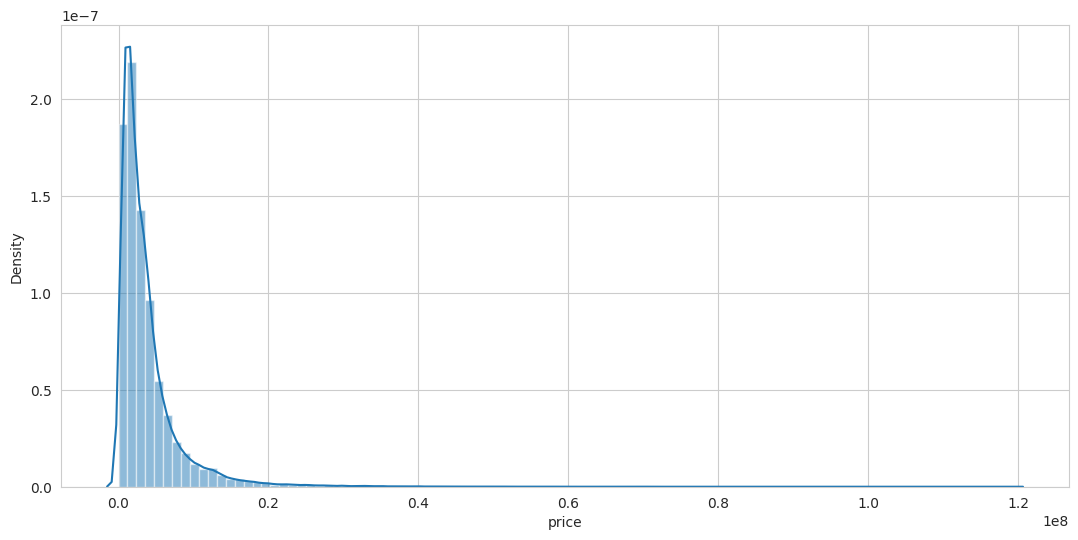

In [ ]:
plt.figure(figsize=(13, 6))
sns.set_style("whitegrid")
sns.distplot(data['price'], kde=True, bins=100, hist_kws={'linewidth': 1, 'alpha': 0.5})
plt.show();

In [ ]:
print('Mean = ', round(data['price'].mean()))
print('Median =', round(data['price'].median()))

Mean =  3779843
Median = 2500000


Видим отчетливый хвост у таргета (у цены), и как следствие большая разница между медианой и средним. Это нужно учитывать

### Гипотезы

  * Как марки влияют на цены, так и модели внутри марок
  * При увеличении возраста авто $-$ уменьшается его стоимость
  * В крупных городах покупают более дорогие автомобили
  * Признак наличия таможенной проверки значительно влияет на цену
  * Основные цвета у авто дороже

### Марки

In [ ]:
print(f'Всего марок - {data["brand"].nunique()}')

Всего марок - 112


Наиболее популярные бренды

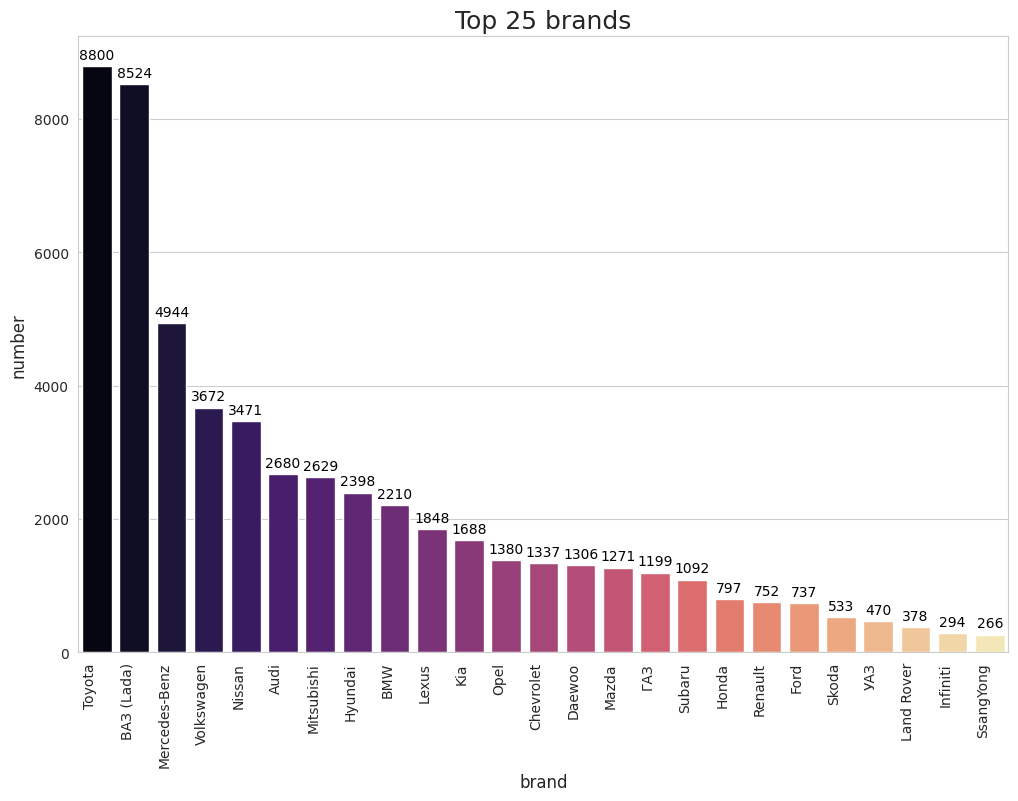

In [ ]:
brand = (data[['brand', 'price']]
         .groupby('brand')[['price']].count().rename(columns={'price':'number'})
         .reset_index().sort_values(by='number', ascending=False).head(25))

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=brand, x='brand', y='number', palette='magma')

for p in ax.patches:
    brand_count = f'{int(p.get_height())}'
    ax.annotate(brand_count, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')

ax.set_xlabel('brand',fontsize=12)
ax.set_xticklabels(brand['brand'].values, rotation=90, ha='right')
ax.set_ylabel('number', fontsize=12)
ax.set_title('Top 25 brands', fontsize=18)

plt.show();

А ниже список наиболее редких марок. Мы их объединим в одну категорию

In [ ]:
data['brand'].value_counts().sort_values(ascending=True).head(60)

Derways              1
ChangFeng            1
Mercury              1
Shuanghuan           1
ЕрАЗ                 1
Aurus                1
LDV                  1
Jin Bei              1
Alpina               1
Plymouth             1
Puch                 1
Dacia                1
Haima                1
Luxgen               1
Oldsmobile           1
King Long            1
ТагАЗ                1
Zotye                1
РАФ                  1
Ferrari              1
Brilliance           2
Buick                2
JMC                  2
Saturn               2
Lancia               2
Hafei                2
ZX                   2
Huanghai             2
Maybach              2
Tianye               2
Aston Martin         3
Mercedes-Maybach     3
BAW                  3
Scion                4
Iran Khodro          4
Maserati             5
Tesla                5
Wuling               5
Chana                7
BYD                  8
Smart                9
Vortex               9
ЛуАЗ                 9
Rolls-Royce

In [ ]:
data['count'] = data['brand'].map(data['brand'].value_counts())
data.loc[data['count'] < 25, 'brand'] = 'Редкий'
data.drop(axis=1, columns=['count'], inplace=True)

Средние цены на популярные бренды

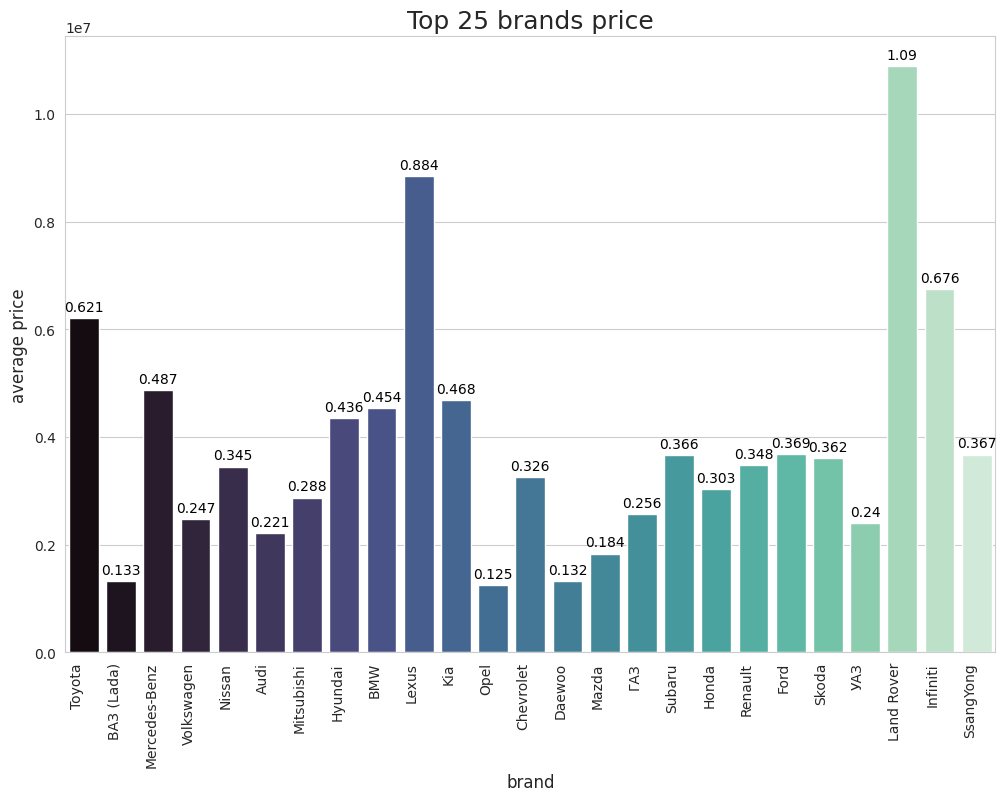

In [ ]:
brand_price = (data[['brand', 'price']]
         .groupby('brand')[['price']].mean().rename(columns={'price':'avg_price'}).reset_index())
brand_price = pd.merge(brand['brand'], brand_price, on='brand')

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=brand_price, x='brand', y='avg_price', palette='mako')

for p in ax.patches:
    brand_count = f'{round(int(p.get_height()) / 1e7, 3)}'
    ax.annotate(brand_count, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')

ax.set_xlabel('brand',fontsize=12)
ax.set_xticklabels(brand['brand'].values, rotation=90, ha='right')
ax.set_ylabel('average price', fontsize=12)
ax.set_title('Top 25 brands price', fontsize=18)

plt.show();

### Модели

Для топ-3 марок выведем наиболее популярные модели, их количество и среднюю стоимость.

In [ ]:
def top_models(brand: str, head=10) -> None:
    """ Отображение количества и средней стоимости моделей зданной марки """
    models = (data[data.brand == brand][['model', 'price']]
              .groupby('model').agg({'price': ['count', 'mean']})
              .reset_index().sort_values(by=('price', 'count'), ascending=False)
              .head(head))

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    sns.barplot(data=models, x='model', y=('price', 'count'), palette='viridis', ax=axs[0])
    axs[0].set_xlabel('models',fontsize=12)
    axs[0].set_xticklabels(models['model'].values, rotation=90, ha='right')
    axs[0].set_ylabel('number', fontsize=12)

    sns.barplot(data=models, x='model', y=('price', 'mean'), palette='mako', ax=axs[1])
    axs[1].set_xlabel('models',fontsize=12)
    axs[1].set_xticklabels(models['model'].values, rotation=90, ha='right')
    axs[1].set_ylabel('average price', fontsize=12)

    plt.tight_layout()
    fig.suptitle(brand, fontsize=18)

    for i in range(2):
        for p in axs[i].patches:
            tmp = f'{round(int(p.get_height()) / 1e7, 3) if i else int(p.get_height())}'
            axs[i].annotate(tmp, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')
    plt.show();

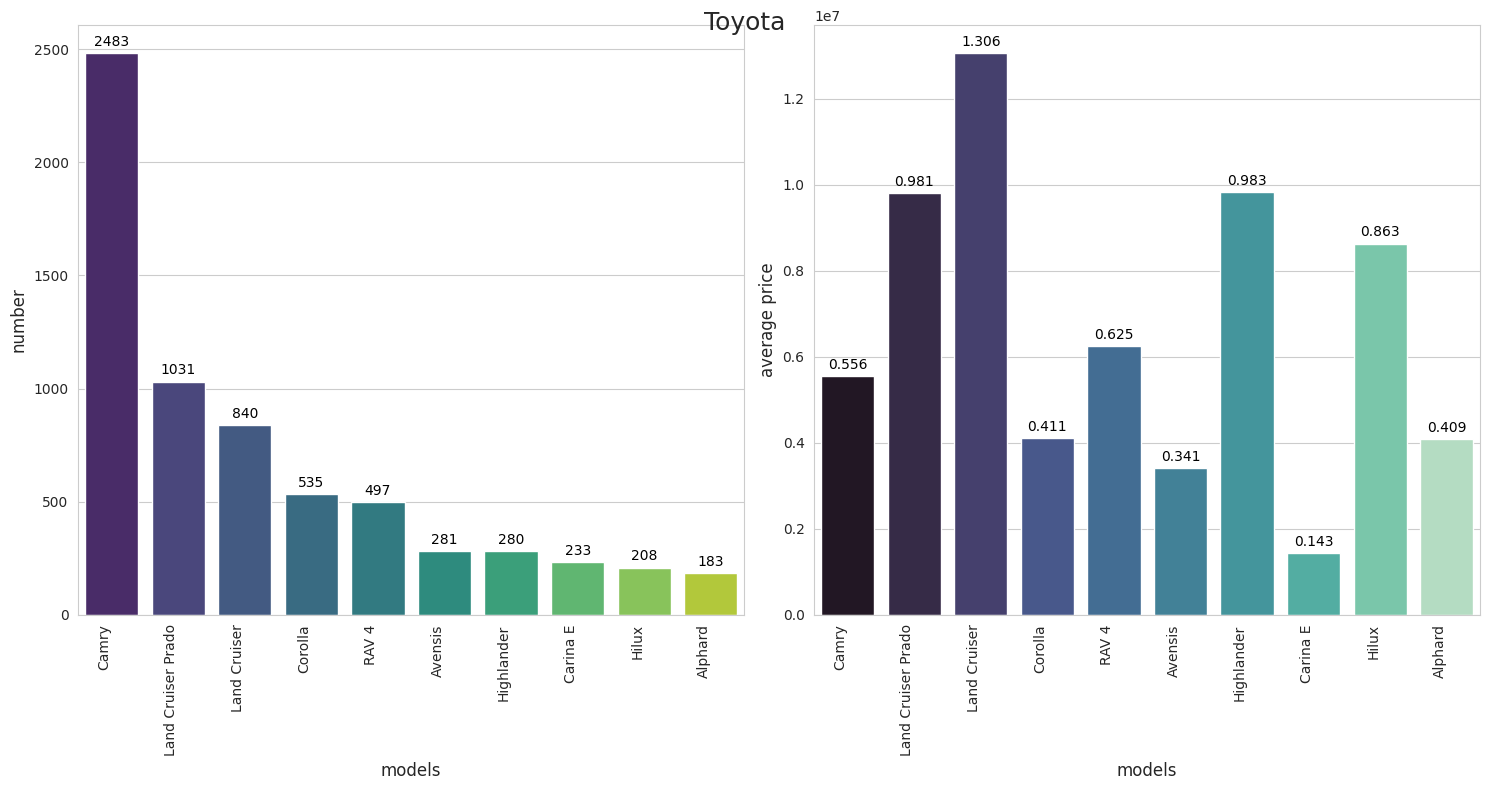

In [ ]:
top_models(brand='Toyota')

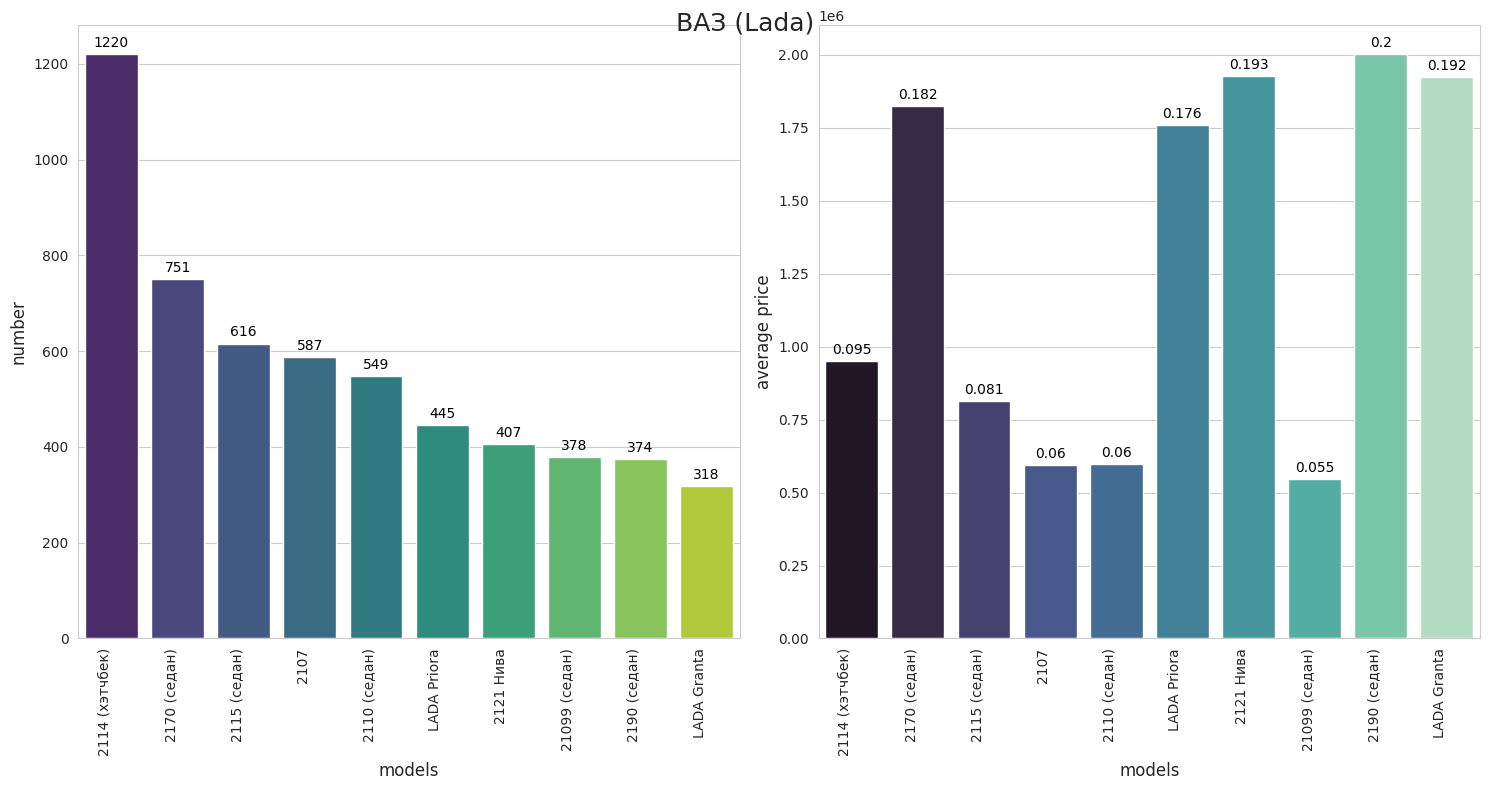

In [ ]:
top_models(brand='ВАЗ (Lada)')

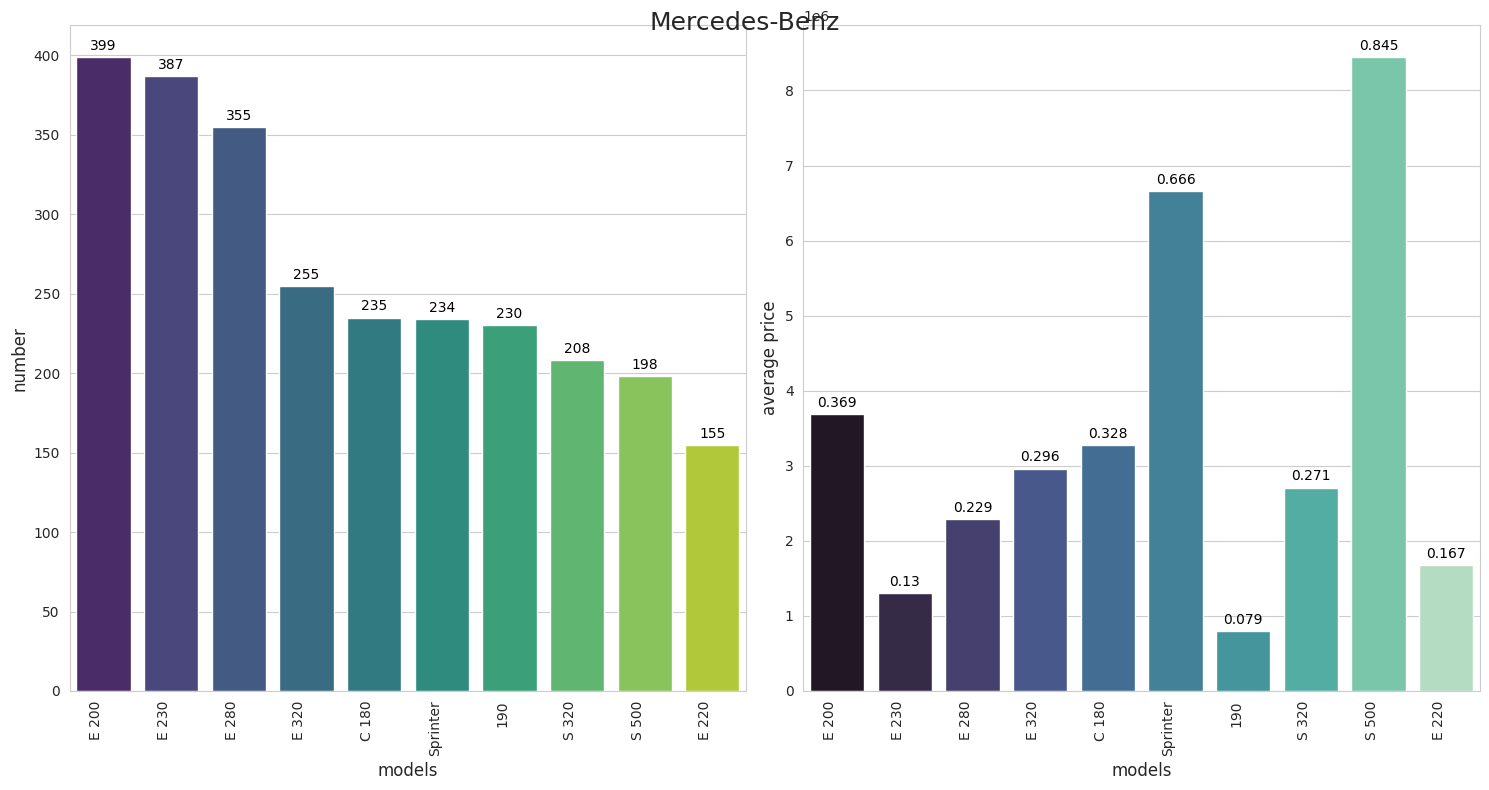

In [ ]:
top_models(brand='Mercedes-Benz')

На цену влияет как бренд, так и определенная модель. Но при построении модели будем учитывать только марку

### Возраст

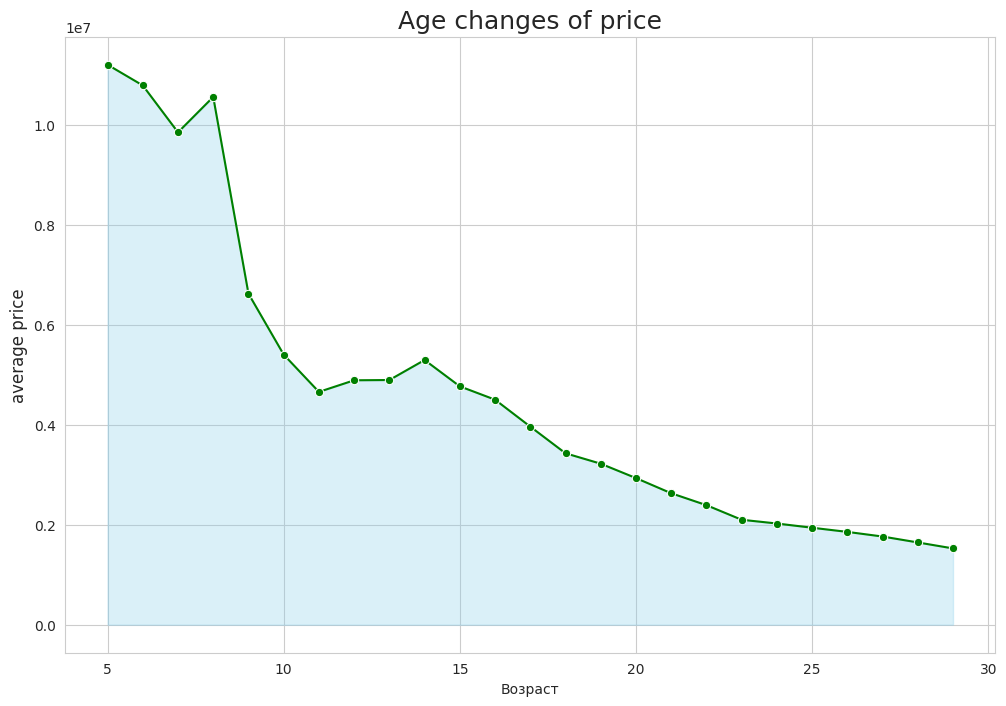

In [ ]:
age = (data[['Возраст', 'price']]
         .groupby('Возраст')[['price']].mean()
         .reset_index().sort_values(by='Возраст'))


plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Возраст', y='price', data=age.iloc[:25], marker='o', color='g')
plt.fill_between(age.iloc[:25].Возраст, age.iloc[:25].price, color='skyblue', alpha=0.3)

ax.set_ylabel('average price', fontsize=12)
ax.set_title('Age changes of price', fontsize=18)
plt.show();

Наблюдается очевидное снижение цены с возростом

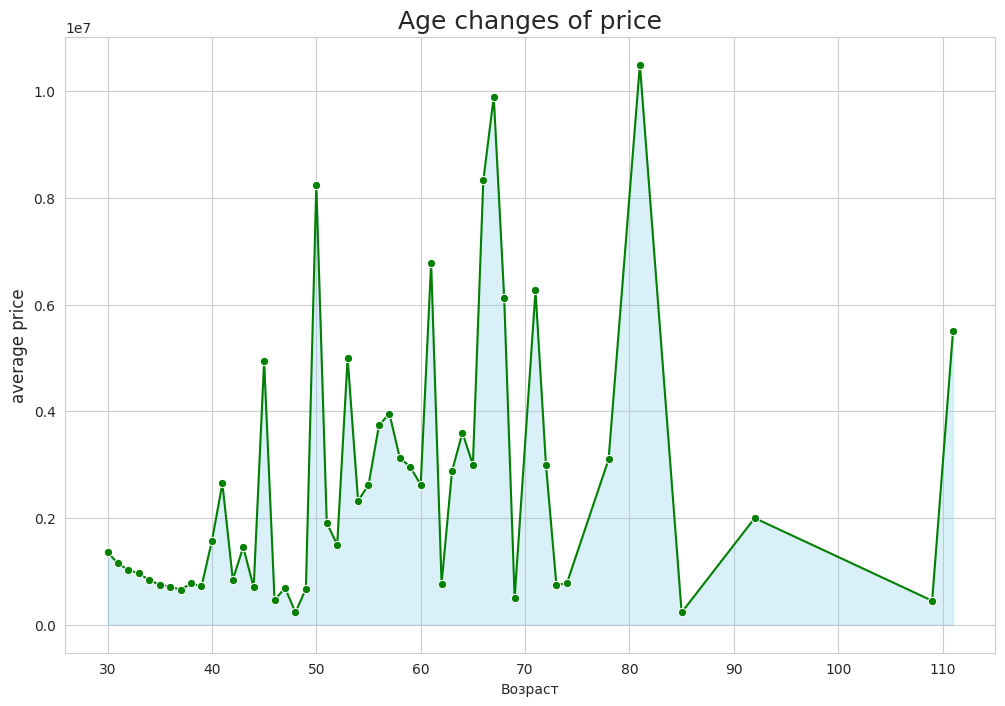

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Возраст', y='price', data=age.iloc[25:], marker='o', color='g')
plt.fill_between(age.iloc[25:].Возраст, age.iloc[25:].price, color='skyblue', alpha=0.3)

ax.set_ylabel('average price', fontsize=12)
ax.set_title('Age changes of price', fontsize=18)
plt.show();

Но у слишком старых автомобилей нет каких-то явных тенденций, поскольку их попросту мало, скорее всего они коллекционные. Объединим группу автомобилей с возрастом 40+ в одну группу

In [ ]:
data['Возраст'] = data['Возраст'].apply(lambda x: x if x < 40 else 40)

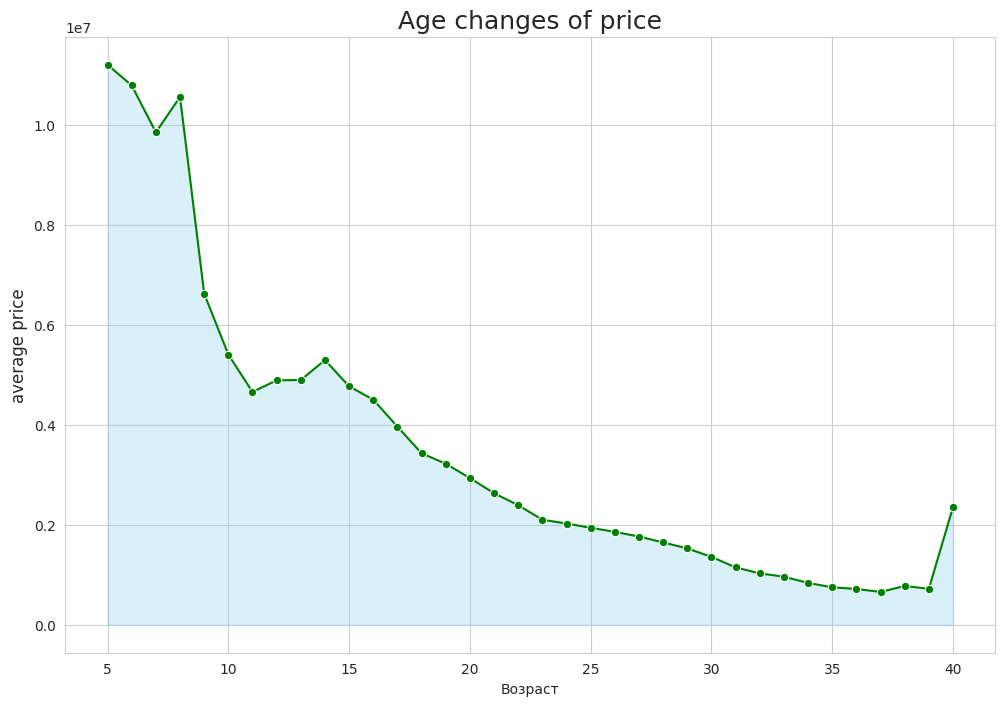

In [ ]:
age = (data[['Возраст', 'price']]
         .groupby('Возраст')[['price']].mean()
         .reset_index().sort_values(by='Возраст'))


plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Возраст', y='price', data=age, marker='o', color='g')
plt.fill_between(age.Возраст, age.price, color='skyblue', alpha=0.3)

ax.set_ylabel('average price', fontsize=12)
ax.set_title('Age changes of price', fontsize=18)
plt.show();

Рассмотрим также распределение количества машин по возрасту

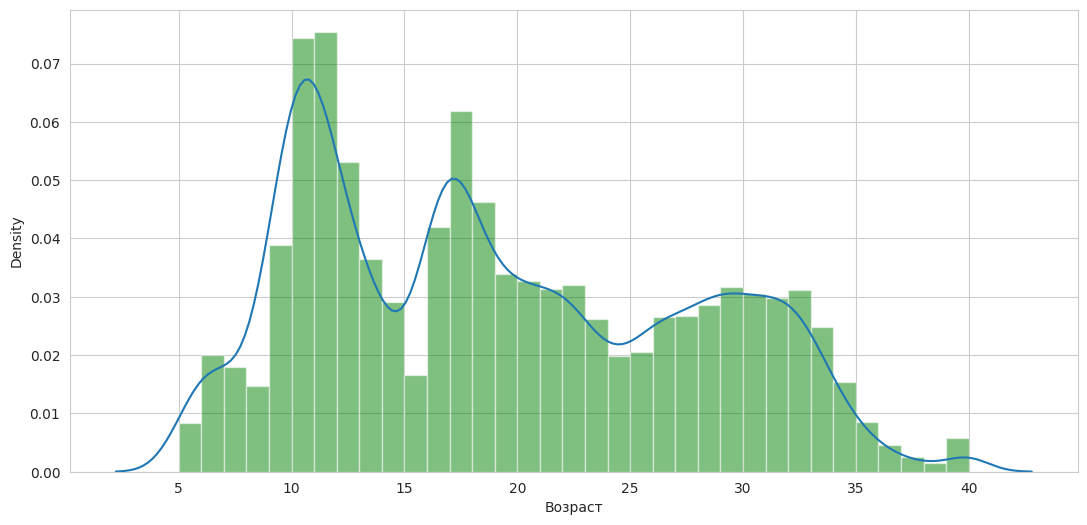

In [ ]:
plt.figure(figsize=(13, 6))
sns.distplot(data['Возраст'], kde=True, bins=35, hist_kws={'color': 'g', 'linewidth': 1, 'alpha': 0.5})
plt.show();

Видим локальный минимум между 15-16 лет $-$ в те времена был кризис, в ходе которого была девальвация, поэтому многие в те времена и не могли позволить себе автомобиль. Такие же кризисные моменты наблюдались и 9 лет назад, и 25 лет назад.

### Город

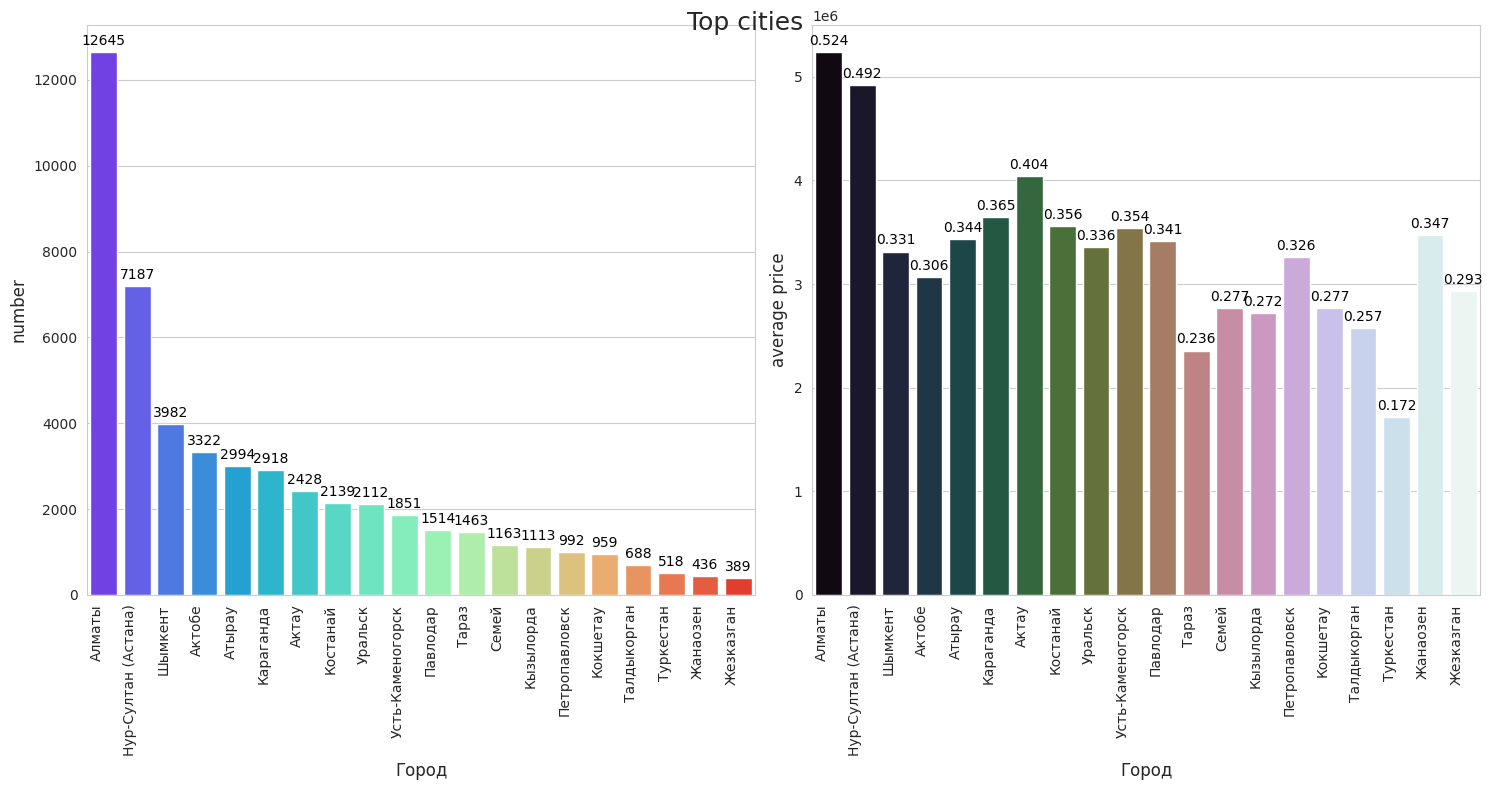

In [ ]:
city = (data[['Город', 'price']]
    .groupby('Город').agg({'price': ['count', 'mean']})
    .reset_index().sort_values(by=('price', 'count'), ascending=False).head(20))

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot(data=city, x='Город', y=('price', 'count'), palette='rainbow', ax=axs[0])
axs[0].set_xlabel('Город',fontsize=12)
axs[0].set_xticklabels(city['Город'].values, rotation=90, ha='right')
axs[0].set_ylabel('number', fontsize=12)

sns.barplot(data=city, x='Город', y=('price', 'mean'), palette='cubehelix', ax=axs[1])
axs[1].set_xlabel('Город',fontsize=12)
axs[1].set_xticklabels(city['Город'].values, rotation=90, ha='right')
axs[1].set_ylabel('average price', fontsize=12)

plt.tight_layout()
fig.suptitle('Top cities', fontsize=18)

for i in range(2):
    for p in axs[i].patches:
        tmp = f'{round(int(p.get_height()) / 1e7, 3) if i else int(p.get_height())}'
        axs[i].annotate(tmp, (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
            textcoords='offset points')

plt.show();

Выше можем наблюдать топ из 20 городов по числу машин. В крупных городах средняя стоимость может быть выше из-за того, что з/п людей выше и они могут себе позволить взять машины по-дороже.

Сам признак `Город` мы не будем использовать для модели, но из него можем получить признак `is_big_city`.

In [ ]:
big_cities = city[city['price', 'mean'] > 0.25 * 1e6]['Город'].values
big_cities

array(['Алматы', 'Нур-Султан (Астана)', 'Шымкент', 'Актобе', 'Атырау',
       'Караганда', 'Актау', 'Костанай', 'Уральск', 'Усть-Каменогорск',
       'Павлодар', 'Тараз', 'Семей', 'Кызылорда', 'Петропавловск',
       'Кокшетау', 'Талдыкорган', 'Туркестан', 'Жанаозен', 'Жезказган'],
      dtype=object)

In [ ]:
data['is_big_city'] = data['Город'].apply(lambda x: x in big_cities)

### Растаможен

Проверим, зависит ли цена от прохождения автомобилем таможенного досмотра.

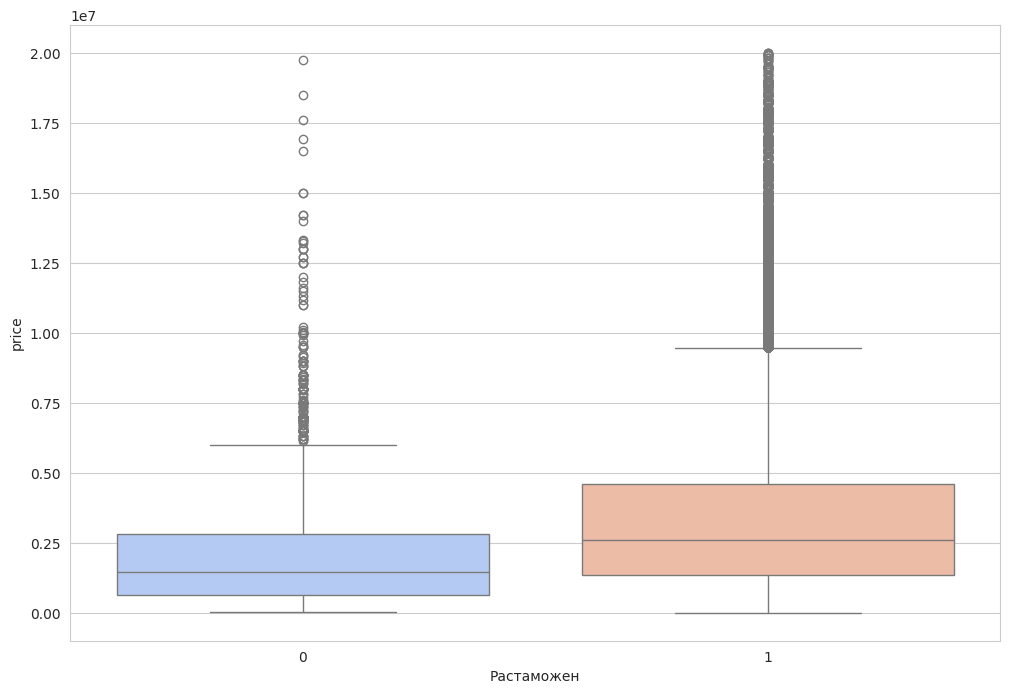

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Растаможен', y='price', data=data[data.price < 20000000], palette='coolwarm');

In [ ]:
print(f'Медиана растаможенного = {round(data[data.Растаможен == 1]["price"].median())}')
print(f'Медиана не растаможенного = {round(data[data.Растаможен == 0]["price"].median())}')

Медиана растаможенного = 2650000
Медиана не растаможенного = 1465000


Медиана растаможенного выше не растаможенного на 80%, что говорит о сильном влиянии на цену данного признака.

### Цвет

In [ ]:
print(data.Цвет.value_counts().index)

Index(['белый', 'черный', 'серебристый', 'серый', 'синий', 'зеленый',
       'красный', 'вишня', 'золотистый', 'бордовый', 'коричневый', 'голубой',
       'бежевый', 'фиолетовый', 'хамелеон', 'жёлтый', 'бронза', 'оранжевый',
       'бирюзовый', 'сиреневый', 'розовый'],
      dtype='object')


Проверим, влияет ли цвет на выбор и на цену. Для начала сгруппируем цвета

In [ ]:
colors = {
  'neutral' : ['белый', 'черный', 'серебристый', 'серый'], # нейтральные
  'bright' : ['зеленый', 'красный', 'вишня', 'жёлтый', 'оранжевый', 'золотистый', 'розовый'], # яркий
  'dark' : ['коричневый', 'бордовый', 'синий', 'фиолетовый', 'хамелеон', 'бронза', 'сиреневый'],  # темные
  'pastel' : ['бежевый', 'бирюзовый',  'голубой'] # пастельные
}
colors = {color: group for group, clrs in colors.items() for color in clrs}

In [ ]:
data['Цвет'] = data['Цвет'].replace(colors)

In [ ]:
data.Цвет.value_counts()

neutral    40989
dark        7543
bright      7516
pastel      1553
Name: Цвет, dtype: int64

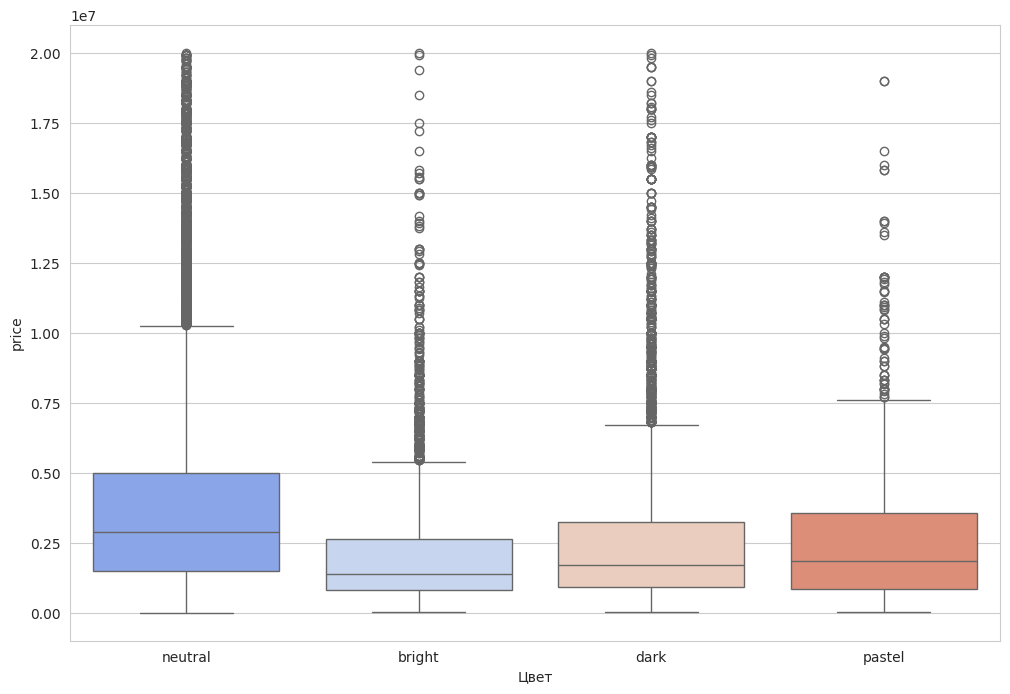

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Цвет', y='price', data=data[data.price < 20000000], palette='coolwarm');

In [ ]:
print(f'Медиана нейтрального = {round(data[data.Цвет == "neutral"]["price"].median())}')
print(f'Медиана яркого = {round(data[data.Цвет == "bright"]["price"].median())}')
print(f'Медиана темного = {round(data[data.Цвет == "dark"]["price"].median())}')
print(f'Медиана пастельного = {round(data[data.Цвет == "pastel"]["price"].median())}')

Медиана нейтрального = 3000000
Медиана яркого = 1400000
Медиана темного = 1700000
Медиана пастельного = 1900000


Нейтральные цвета (основные) несколько выше по ценам, чем автомобили из других групп.

## Моделирование

Определим метрики, которые мы будем использовать для оценки качества моделей

In [ ]:
def rmse(y: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """ Root Mean Squared Error (RMSE) metric """
    return np.sqrt(mean_squared_error(y, y_pred))


def r2_adjusted(X_test: np.ndarray, y: np.ndarray, y_pred: np.ndarray) -> float:
    """ Скорректированный R2 """
    N = X_test.shape[0] # число объектов
    K = X_test.shape[1] # число признаков
    r2 = r2_score(y, y_pred)
    return 1 - (1 - r2) * (N - 1) / (N - K - 1)

def get_metrics(X_test: np.ndarray, y_test: np.ndarray, y_pred: np.ndarray, name:str) -> pd.DataFrame:
    """ Вернуть все метрики """

    metrics = pd.DataFrame()

    metrics['model'] = [name]

    metrics['MSE'] = mean_squared_error(y_test, y_pred)
    metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    metrics['RMSE'] = rmse(y_test, y_pred)
    metrics['MAPE'] = mean_absolute_percentage_error(y_test, y_pred)
    metrics['R2'] = r2_adjusted(X_test, y_test, y_pred)

    return metrics

### Обработка категориальных признаков

Используем кодировку категориальных признаков средними значениями целевой переменной внутри каждой категории (для линейной регрессии)

In [ ]:
data.columns

Index(['brand', 'model', 'price', 'Город', 'Коробка передач', 'Кузов',
       'Привод', 'Растаможен', 'Руль', 'Цвет', 'Пробег', 'Возраст',
       'Объем двигателя', 'ДВС', 'is_big_city'],
      dtype='object')

In [ ]:
cols_drop = ['model', 'Город']
data = data.drop(cols_drop, axis=1)

In [ ]:
data['is_big_city'] = data['is_big_city'].replace({True: 1, False: 0})

In [ ]:
cat_features = ['brand', 'Коробка передач', 'Кузов', 'Привод', 'Руль', 'Цвет', 'ДВС']
data_cat = data.copy()

In [ ]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, target):
        self.cols = cols
        self.mapping = {}
        self.target = target

    def fit(self, X):
        for col in self.cols:
            self.mapping[col] = X.groupby(col)[self.target].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.mapping[col])
        return X_copy

In [ ]:
encoder = MeanTargetEncoder(cols=cat_features, target='price')
data = encoder.fit_transform(data)

In [ ]:
data.head()

,brand,price,Коробка передач,Кузов,Привод,Растаможен,Руль,Цвет,Пробег,Возраст,Объем двигателя,ДВС,is_big_city
1,4.542959e+06,5500000,5.208028e+06,6.139572e+06,6.729539e+06,1,3.900186e+06,4.327955e+06,170,15,4.8,3.772047e+06,1
3,2.875196e+06,3200000,6.286556e+06,6.139572e+06,6.729539e+06,1,3.900186e+06,4.327955e+06,120000,21,2.4,3.772047e+06,1
4,3.965135e+06,3900000,1.811886e+06,2.831756e+06,2.925114e+06,1,3.900186e+06,4.327955e+06,1200,40,2.4,3.772047e+06,1
6,4.542959e+06,3800000,6.286556e+06,2.831756e+06,6.729539e+06,1,3.900186e+06,2.066025e+06,130000,18,3.0,3.772047e+06,1
8,4.542959e+06,2300000,6.286556e+06,2.831756e+06,2.925114e+06,1,3.900186e+06,4.327955e+06,200000,22,4.4,3.772047e+06,1


### Train-test split

In [ ]:
X = data.drop(['price'], axis=1)
y = data['price'] # target

In [ ]:
train, test = train_test_split(
    np.arange(X.shape[0]),
    test_size=TEST_SIZE,
    shuffle=True,
    random_state=RANDOM_STATE
)

train_, val = train_test_split(
    np.arange(train.shape[0]),
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

### LinearRegrission (baseline)

Простая линейная регрессия без параметров

In [ ]:
lr_base = LinearRegression()
lr_base.fit(X.iloc[train], y.iloc[train])

LinearRegression()

In [ ]:
y_pred = lr_base.predict(X.iloc[test])

In [ ]:
results = get_metrics(X.iloc[test], y.iloc[test], y_pred, name='Baseline LinearRegression')
results

,model,MSE,MAE,RMSE,MAPE,R2
0,Baseline LinearRegression,8.719837e+12,1.673545e+06,2.952937e+06,0.916985,0.558605


### CatBoost (baseline)



Для начала используем CatBoost градиентный бустинг. В качестве метрики качества будем ориентироваться на MAE, так как она не зависит от распределения

In [ ]:
X_cat = data_cat.drop(['price'], axis=1)

cat_base = CatBoostRegressor(
          loss_function='MAE',
          eval_metric='MAE',
          cat_features=cat_features,
          random_state=RANDOM_STATE
)

cat_base.fit(
    X_cat.iloc[train_], y.iloc[train_],
    eval_set = ((X_cat.iloc[val], y.iloc[val])),
    early_stopping_rounds=100
)

0:	learn: 2556742.4516838	test: 2622226.6128350	best: 2622226.6128350 (0)	total: 207ms	remaining: 3m 27s
1:	learn: 2502028.8860717	test: 2566535.6268695	best: 2566535.6268695 (1)	total: 376ms	remaining: 3m 7s
2:	learn: 2445860.3640217	test: 2509129.5464571	best: 2509129.5464571 (2)	total: 511ms	remaining: 2m 49s
3:	learn: 2394360.4008284	test: 2456168.9861941	best: 2456168.9861941 (3)	total: 659ms	remaining: 2m 43s
4:	learn: 2348478.5425497	test: 2409245.2987441	best: 2409245.2987441 (4)	total: 804ms	remaining: 2m 40s
5:	learn: 2299073.4322483	test: 2358856.8496267	best: 2358856.8496267 (5)	total: 928ms	remaining: 2m 33s
6:	learn: 2254711.5300626	test: 2314025.4701203	best: 2314025.4701203 (6)	total: 1.17s	remaining: 2m 45s
7:	learn: 2211512.0641037	test: 2269043.7621788	best: 2269043.7621788 (7)	total: 1.38s	remaining: 2m 50s
8:	learn: 2169219.2077343	test: 2226310.7173508	best: 2226310.7173508 (8)	total: 1.53s	remaining: 2m 48s
9:	learn: 2127658.2316451	test: 2184069.3302655	best: 21

In [ ]:
y_pred = cat_base.predict(X_cat.iloc[test])

In [ ]:
results = results.append(get_metrics(X_cat.iloc[test], y.iloc[test], y_pred, name='Baseline CatBoost'))
results

,model,MSE,MAE,RMSE,MAPE,R2
0,Baseline LinearRegression,8.719837e+12,1.673545e+06,2.952937e+06,0.916985,0.558605
0,Baseline CatBoost,2.171188e+12,5.894442e+05,1.473495e+06,0.276923,0.890095


### LightGBM (baseline)

Будем использовать также LightGBM градиентный бустинг

In [ ]:
# train = lgb.Dataset(X_train_, y_train_, categorical_feature=cat_features)
# val = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

# gbm_base = lgb.train({'objective': 'regression', 'metric': 'mae'},
#                     train_set=train, valid_sets=(val,),
#                     num_boost_round=100)
gbm_base = LGBMRegressor(objective='mae', random_state=RANDOM_STATE)
gbm_base.fit(
    X.iloc[train_], y.iloc[train_],
    eval_metric='mae',
    eval_set = ((X.iloc[val], y.iloc[val])),
    categorical_feature=cat_features
)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Found whitesp

LGBMRegressor(objective='mae', random_state=4242)

In [ ]:
y_pred = gbm_base.predict(X.iloc[test])

In [ ]:
results = results.append(get_metrics(X.iloc[test], y.iloc[test], y_pred, name='Baseline LGBM'))
results

,model,MSE,MAE,RMSE,MAPE,R2
0,Baseline LinearRegression,8.719837e+12,1.673545e+06,2.952937e+06,0.916985,0.558605
0,Baseline CatBoost,2.171188e+12,5.894442e+05,1.473495e+06,0.276923,0.890095
0,Baseline LGBM,2.314980e+12,5.777536e+05,1.521506e+06,0.273338,0.882816


### Optuna

Optuna – инструмент подбора оптимальных гиперпараметров, который использует байесовский подход для автоматизации пространства поиска гиперпараметров. Попробуем использовать Optuna на LGBM, поскольку эта модель градиентного бустинга быстрее обучается и менее требовательна к ресурсам, в отличие от CatBoost

In [ ]:
def objective_gbm(trial, X, y) -> np.float64:
    """ Целевая функция поиска парметров """
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300, step=1), # количество листьев в деревьях
        'max_depth': trial.suggest_int('max_depth', 3, 15, step=2), # максимальная глубина
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200, step=10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.001, 100),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.001, 100),
        'min_gain_to_split': trial.suggest_int('min_gain_to_split', 0, 15), # минимальный инф. выигрыш
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'objective': trial.suggest_categorical('objective', ['mae']),
        'random_state': trial.suggest_categorical('random_state', [RANDOM_STATE])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        gbm = LGBMRegressor(**param_grid)
        gbm.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  categorical_feature=cat_features,
                  eval_metric='mae')
        preds = gbm.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LGB')
handle = lambda trial: objective_gbm(trial, X.iloc[train], y.iloc[train])
# n_trials - кол-во итераций
study.optimize(handle, n_trials=20, show_progress_bar=True)

[I 2024-02-16 00:32:15,080] A new study created in memory with name: LGB


  0%|          | 0/20 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
print(f'Best value (mae): {study.best_value:.5f}')
print(f'Best params: {study.best_params}')

Best value (mae): 566123.06490
Best params: {'n_estimators': 500, 'learning_rate': 0.08655240822701708, 'num_leaves': 247, 'max_depth': 7, 'min_child_samples': 5, 'lambda_l1': 0.008025256603738373, 'lambda_l2': 10.62016925956503, 'min_gain_to_split': 0, 'feature_fraction': 0.838423116960115, 'objective': 'mae', 'random_state': 4242}


In [ ]:
best_params = {'n_estimators': 500,
               'learning_rate': 0.08655240822701708,
               'num_leaves': 247, 'max_depth': 7, 'min_child_samples': 5,
               'lambda_l1': 0.008025256603738373, 'lambda_l2': 10.62016925956503,
               'min_gain_to_split': 0, 'feature_fraction': 0.838423116960115,
               'objective': 'mae',
               'random_state': 4242}

Оптимальные параметры найдены. Посмотрим, какие из них вносят больший вклад

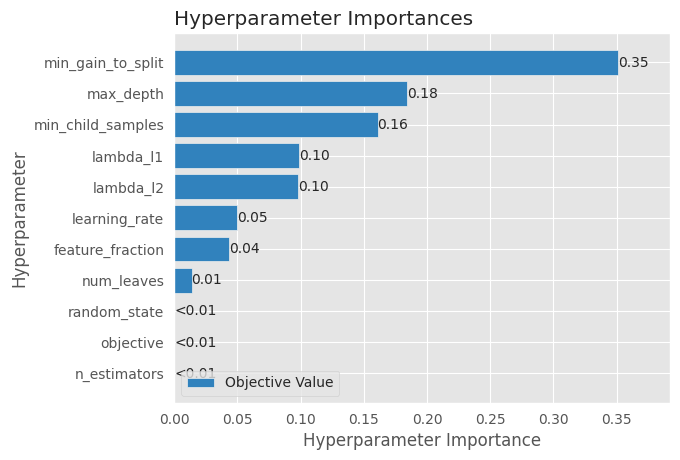

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study);

Наибольшее влияние оказывает гиперпарметр – минимальный информационный выигрыш разбиения.

Проверим метрики с полученными параметрами

In [ ]:
gbm_opt = LGBMRegressor(**study.best_params)
gbm_opt.fit(
    X.iloc[train_], y.iloc[train_],
    eval_metric='mae',
    categorical_feature=cat_features,
    eval_set = ((X.iloc[val], y.iloc[val]))
)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.838423116960115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838423116960115
[LightGBM] [Warning] lambda_l2 is set=10.62016925956503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.62016925956503
[LightGBM] [Warning] lambda_l1 is set=0.008025256603738373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008025256603738373
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.838423116960115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838423116960115
[LightGBM] [Warning] lambda_l2 is set=10.62016925956503, reg_lambda=0.0 will be ignored. Current value: lam

LGBMRegressor(feature_fraction=0.838423116960115,
              lambda_l1=0.008025256603738373, lambda_l2=10.62016925956503,
              learning_rate=0.08655240822701708, max_depth=7,
              min_child_samples=5, min_gain_to_split=0, n_estimators=500,
              num_leaves=247, objective='mae', random_state=4242)

In [ ]:
y_pred = gbm_opt.predict(X.iloc[test])

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.838423116960115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838423116960115
[LightGBM] [Warning] lambda_l2 is set=10.62016925956503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.62016925956503
[LightGBM] [Warning] lambda_l1 is set=0.008025256603738373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008025256603738373


In [ ]:
results = results.append(get_metrics(X.iloc[test], y.iloc[test], y_pred, name='Optuna LGBM'))
results

,model,MSE,MAE,RMSE,MAPE,R2
0,Baseline LinearRegression,8.719837e+12,1.673545e+06,2.952937e+06,0.916985,0.558605
0,Baseline CatBoost,2.171188e+12,5.894442e+05,1.473495e+06,0.276923,0.890095
0,Baseline LGBM,2.314980e+12,5.777536e+05,1.521506e+06,0.273338,0.882816
0,Optuna LGBM,1.559441e+12,5.142390e+05,1.248776e+06,0.249657,0.921062


Можно пробовать и дальнейшее улучшение путем увеличения числа итераций поиска параметров.

### Результаты

In [ ]:
results.iloc[:, :4].style.highlight_min(axis=0, color='darkblue')

,MSE,MAE,RMSE,MAPE
model,,,,
Baseline LinearRegression,8719836873005.283203,1673544.741658,2952936.991032,0.916985
Baseline CatBoost,2171187930605.306885,589444.231243,1473495.141019,0.276923
Baseline LGBM,2314980161621.430664,577753.554003,1521505.886161,0.273338
Optuna LGBM,1559440784103.264160,514238.989514,1248775.714091,0.249657


Оптимизация гиперпараметров была проведена успешно и привела к наилучшим метрикам.

## Feature importance

Используем `Permutation Importance` для выявления значимых признаков для модели LGBM Optuna

In [ ]:
pi = permutation_importance(gbm_opt, X.iloc[test], y.iloc[test], n_repeats=10)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.838423116960115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838423116960115
[LightGBM] [Warning] lambda_l2 is set=10.62016925956503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.62016925956503
[LightGBM] [Warning] lambda_l1 is set=0.008025256603738373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008025256603738373
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.838423116960115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838423116960115
[LightGBM] [Warning] lambda_l2 is set=10.62016925956503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.62016925956503
[LightGBM] [Warning] lambda_l1 is set=0.008025256603738

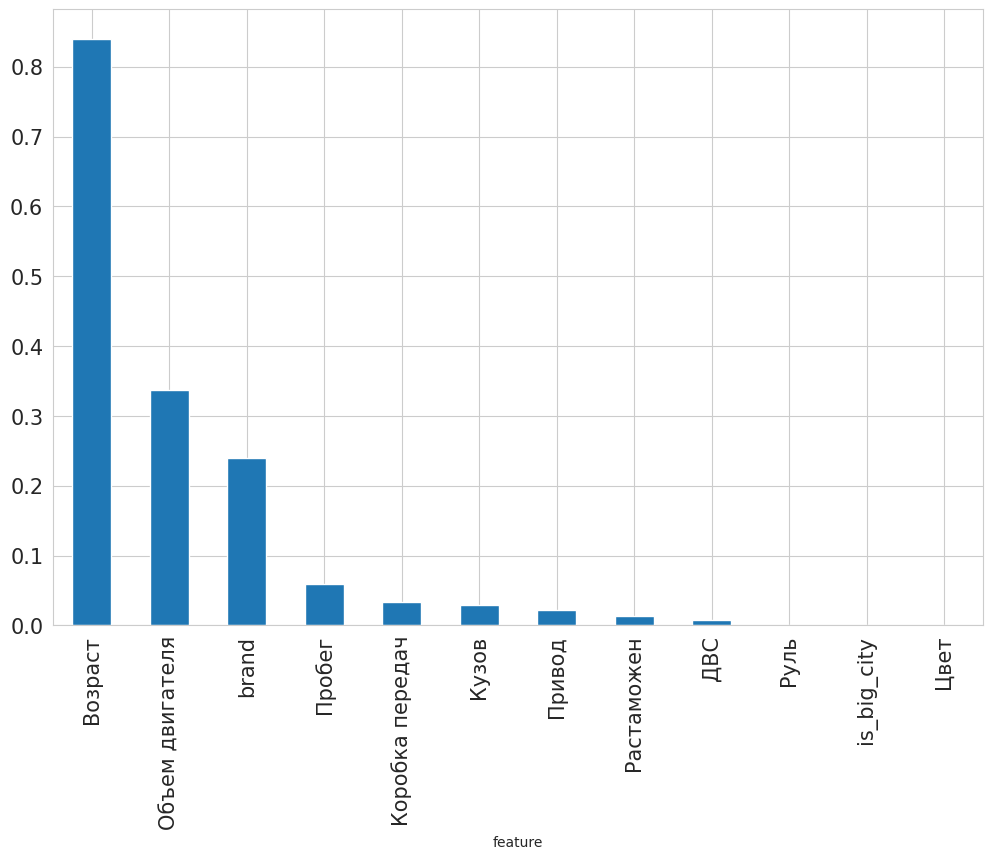

In [ ]:
perm_df = pd.DataFrame((pi['importances_mean'], X.iloc[train].columns.to_list()), index=('score', 'feature'))
perm_df = perm_df.T.sort_values(ascending=False, by='score')
perm_df.set_index('feature')['score'].plot.bar(figsize=(12, 8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();

Весомыми признаками для LGBM являются возраст автомобиля (что логично), объем двигателя (расположен на втором месте и немного неожиданно). Как я и утверждал, марка автомобиля тоже имеет место быть при образовании цен. Остальные параметры в гораздо меньшей степени формируют нашу цену.